In [2]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
from numpy.random import normal, choice, rand, beta, binomial, randint, dirichlet
from numpy.linalg import matrix_rank, norm, svd, eig, qr
from scipy.linalg import pinv2
from scipy import interpolate
from scipy.stats import entropy
def pinv(x): return pinv2(x, rcond=10 * np.finfo(float).eps)
import time

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
ncfile = Dataset("../data/air.202010.nc")
air = np.squeeze(ncfile.variables['air'])
ncfile.close()
air = air[:,16,:252,1:337]

In [4]:
A = air
del air
N = A.shape

In [5]:
N

(248, 252, 336)

In [6]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [7]:
def HOSVD(A):
    start_time = time.time()
    A1 = A.reshape(A.shape[0],A.shape[1]*A.shape[2]) # 1 2 3
    tmp = np.moveaxis(A,0,2) # 2 3 1
    A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    tmp = np.moveaxis(A,2,0) # 3 1 2
    A3 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
    U1, s1, V1 = svd(A1,full_matrices=False)
    U2, s2, V2 = svd(A2,full_matrices=False)
    U3, s3, V3 = svd(A3,full_matrices=False)
    
    S = np.tensordot(np.tensordot(np.tensordot(A,U1.T,axes=(0,1)),
                              U2.T,axes=(0,1)),
                 U3.T,axes=(0,1))
    #print("--- %s seconds ---" % (time.time() - start_time))
    return S, U1, U2, U3

def linear(index,score,N):
    f = interpolate.interp1d(index, score)
    z = f(np.arange(N))
    z[index] = 0
    if np.sum(z) > 0:
        return z / np.sum(z)
    if np.sum(z) == 0:
        return None

In [8]:
def tt(A,rank):
    start = time.time()
    d = len(A.shape)
    r = [1]
    G = []
    C = A
    for k in range(1,d):
        C = C.reshape((np.int(r[k-1]*A.shape[k-1]),np.int(C.size/r[k-1]/A.shape[k-1])),order='F')
        U, s, VT = svd(C, full_matrices=False)
        r.append(rank[k-1])
        U = U[:, :r[k]]
        s = s[:r[k]]
        VT = VT[:r[k], :]
        G.append(U.reshape((r[k-1],A.shape[k-1],r[k]),order='F'))
        C = np.dot(np.diag(s),VT)
    G.append(C[:,:,np.newaxis])
    
    A_lowrank = G[0].reshape(A.shape[0], -1)
    A_lowrank = A_lowrank.dot(G[1].reshape(r[1],-1)).reshape(-1,r[2])
    A_lowrank = A_lowrank.dot(G[2].reshape(r[2],-1)).reshape(A.shape[0],A.shape[1],A.shape[2])
    
    end = time.time()
    print('Decomposition Finished in {}'.format(end - start))
    err = norm(A_lowrank - A)**2 / norm(A)**2
    print('approximation error: {}'.format(err))
    return end - start, err, A_lowrank

In [9]:
def tt_RDSVD(A,rank,l):
    start = time.time()
    d = len(A.shape)
    r = [1]
    G = []
    C = A
    for k in range(1,d):
        C = C.reshape((np.int(r[k-1]*A.shape[k-1]),np.int(C.size/r[k-1]/A.shape[k-1])),order='F')
        U, s, VT = RD_SCSVD(C, rank[k-1], 10, 10, l[k-1])
        r.append(rank[k-1])
        U = U[:, :r[k]]
        s = s[:r[k],:r[k]]
        VT = VT[:r[k], :]
        print(U.shape)
        G.append(U.reshape((r[k-1],A.shape[k-1],r[k]),order='F'))
        C = np.dot(s,VT)
    G.append(C[:,:,np.newaxis])
    
    A_lowrank = G[0].reshape(A.shape[0], -1)
    A_lowrank = A_lowrank.dot(G[1].reshape(r[1],-1)).reshape(-1,r[2])
    A_lowrank = A_lowrank.dot(G[2].reshape(r[2],-1)).reshape(A.shape[0],A.shape[1],A.shape[2])
    
    end = time.time()
    print('Decomposition Finished in {}'.format(end - start))
    err = norm(A_lowrank - A)**2 / norm(A)**2
    print('approximation error: {}'.format(err))
    return end - start, err, A_lowrank

In [10]:
def tt_PGSVD(A,rank,l):
    start = time.time()
    d = len(A.shape)
    r = [1]
    G = []
    C = A
    for k in range(1,d):
        C = C.reshape((np.int(r[k-1]*A.shape[k-1]),np.int(C.size/r[k-1]/A.shape[k-1])),order='F')
        U, s, VT = PG_SCSVD(C, rank[k-1], 10, 10, l[k-1])
        r.append(rank[k-1])
        U = U[:, :r[k]]
        s = s[:r[k],:r[k]]
        VT = VT[:r[k], :]
        G.append(U.reshape((r[k-1],A.shape[k-1],r[k]),order='F'))
        C = np.dot(s,VT)
    G.append(C[:,:,np.newaxis])
    
    A_lowrank = G[0].reshape(A.shape[0], -1)
    A_lowrank = A_lowrank.dot(G[1].reshape(r[1],-1)).reshape(-1,r[2])
    A_lowrank = A_lowrank.dot(G[2].reshape(r[2],-1)).reshape(A.shape[0],A.shape[1],A.shape[2])
    
    end = time.time()
    print('Decomposition Finished in {}'.format(end - start))
    err = norm(A_lowrank - A)**2 / norm(A)**2
    print('approximation error: {}'.format(err))
    return end - start, err, A_lowrank

In [11]:
def PG_SCSVD(A,r,start,step,stop):
    N = A.shape
    m = np.array([start,start],dtype=np.int)
    params = [1,1]
    
    # computation time log
    #start_time = time.time()
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,np.array([0,N[0]-1]))
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,np.array([0,N[1]-1]))

    # leverage scores
    score_0 = np.sum(np.abs(np.diff(A[index_0,:],axis=1)),axis=1)
    score_1 = np.sum(np.abs(np.diff(A[:,index_1],axis=0)),axis=0)
    
    # interpolation
    z_0 = linear(index_0,score_0,N[0])
    z_1 = linear(index_1,score_1,N[1])
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            score_0 = np.sum(np.abs(np.diff(A[index_0,:],axis=1)),axis=1)
            z_0 = linear(index_0,score_0,N[0])
            params[0] = entropy(score_0)
        
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            score_1 = np.sum(np.abs(np.diff(A[:,index_1],axis=0)),axis=0)
            z_1 = linear(index_1,score_1,N[1])
            params[1] = entropy(score_1)
            
    #time_TS = time.time() - start_time

    # Final SCSVD
    k = np.array(max(r + (np.min(m) - r)/3,r),dtype=np.int)
    s = np.array(max(r + 2*(np.min(m) - r)/3,r),dtype=np.int)
    
    Map = normal(size=(k,m[0]))
    Map_T = normal(size=(m[1],k))
    MapL = normal(size=(s,m[0]))
    MapR = normal(size=(s,m[1]))
    
    X = Map @ A[index_0,:]
    Y = A[:,index_1] @ Map_T
    delta, theta = np.meshgrid(index_0, index_1, indexing='ij')
    Z = MapL @ A[delta,theta] @ MapR.T
    
    P, _ = qr(np.array(X.T))
    Q, _ = qr(np.array(Y))

    C = pinv(MapL @ Q[index_0,:]).dot(Z).dot(pinv(MapR @ P[index_1,:]).T)
    U, s, VT = svd(C)
    Cr = U[:,:r].dot(np.diag(s[:r])).dot(VT[:r,:])
    
    #Ar = A[:,fibers_1].dot(Z).dot(A[fibers_0,:])
    
    #err = norm(A - Ar)**2 / norm(A)**2
    
    return Q, Cr, P.T

In [22]:
def RD_SCSVD(A,r,start,step,stop):
    N = A.shape
    m = np.array([start,start],dtype=np.int)
    params = [1,1]
    
    # computation time log
    #start_time = time.time()
    
    # inital core uniform sampling
    index_0 = np.append(choice(N[0]-2,start-2,replace=False)+1,np.array([0,N[0]-1]))
    index_1 = np.append(choice(N[1]-2,start-2,replace=False)+1,np.array([0,N[1]-1]))
    
    # interpolation
    z_0 = np.ones(N[0])
    z_0[index_0] = 0
    z_0 = z_0/np.sum(z_0)
    
    z_1 = np.ones(N[1])
    z_1[index_1] = 0
    z_1 = z_1/np.sum(z_1)
    
    while np.sum(m) < stop:
        theta = np.array(dirichlet(params,1)[0] * step,dtype=np.int)
        
        if z_0 is not None:
            if np.sum(z_0>0) > theta[0]:
                add = theta[0]
            else:
                add = np.sum(z_0>0)
            m[0] += add
            index_0 = np.append(index_0,choice(N[0],add,replace=False,p=z_0))
            score_0 = np.sum(np.abs(np.diff(A[index_0,:],axis=1)),axis=1)
            z_0[index_0] = 0
            if np.sum(z_0) > 0:
                z_0 = z_0/np.sum(z_0)
            if np.sum(z_0) == 0:
                z_0 = None
        
        if z_1 is not None:
            if np.sum(z_1>0) > theta[1]:
                add = theta[1]
            else:
                add = np.sum(z_1>0)
            m[1] += add
            index_1 = np.append(index_1,choice(N[1],add,replace=False,p=z_1))
            score_1 = np.sum(np.abs(np.diff(A[:,index_1],axis=0)),axis=0)
            z_1[index_1] = 0
            if np.sum(z_1) > 0:
                z_1 = z_1/np.sum(z_1)
            if np.sum(z_1) == 0:
                z_1 = None
            
    #time_TS = time.time() - start_time

    # Final SCSVD
    k = np.array(max(r + (np.min(m) - r)/3,r),dtype=np.int)
    s = np.array(max(r + 2*(np.min(m) - r)/3,r),dtype=np.int)
    
    Map = normal(size=(k,m[0]))
    Map_T = normal(size=(m[1],k))
    MapL = normal(size=(s,m[0]))
    MapR = normal(size=(s,m[1]))
    
    X = Map @ A[index_0,:]
    Y = A[:,index_1] @ Map_T
    delta, theta = np.meshgrid(index_0, index_1, indexing='ij')
    Z = MapL @ A[delta,theta] @ MapR.T
    
    P, _ = qr(np.array(X.T))
    Q, _ = qr(np.array(Y))

    C = pinv(MapL @ Q[index_0,:]).dot(Z).dot(pinv(MapR @ P[index_1,:]).T)
    U, s, VT = svd(C)
    Cr = U[:,:r].dot(np.diag(s[:r])).dot(VT[:r,:])
    
    #Ar = A[:,fibers_1].dot(Z).dot(A[fibers_0,:])
    
    #err = norm(A - Ar)**2 / norm(A)**2
    
    return Q, Cr, P.T

In [31]:
def tt_RDSVD_log(A,rank):
    d = len(A.shape)
    
    err_log = []
    for p in np.linspace(0.0005,0.01,10):
        r = [1]
        G = []
        C = A
        l = [np.int(p*(A.shape[0] + A.shape[1]*A.shape[2])),np.int(p*(rank[0]*A.shape[1] + A.shape[2]))]
        for k in range(1,d):
            C = C.reshape((np.int(r[k-1]*A.shape[k-1]),np.int(C.size/r[k-1]/A.shape[k-1])),order='F')
            U, s, VT = RD_SCSVD(C, rank[k-1], 10, 10, l[k-1])
            r.append(rank[k-1])
            U = U[:, :r[k]]
            s = s[:r[k],:r[k]]
            VT = VT[:r[k], :]
            G.append(U.reshape((r[k-1],A.shape[k-1],r[k]),order='F'))
            C = np.dot(s,VT)
        G.append(C[:,:,np.newaxis])

        A_lowrank = G[0].reshape(A.shape[0], -1)
        A_lowrank = A_lowrank.dot(G[1].reshape(r[1],-1)).reshape(-1,r[2])
        A_lowrank = A_lowrank.dot(G[2].reshape(r[2],-1)).reshape(A.shape[0],A.shape[1],A.shape[2])

        err_log.append(norm(A_lowrank - A)**2 / norm(A)**2)

    return err_log

In [35]:
def tt_PGSVD_log(A,rank):
    d = len(A.shape)
    
    err_log = []
    for p in np.linspace(0.0005,0.01,10):
        r = [1]
        G = []
        C = A
        l = [np.int(p*(A.shape[0] + A.shape[1]*A.shape[2])),np.int(p*(rank[0]*A.shape[1] + A.shape[2]))]
        for k in range(1,d):
            C = C.reshape((np.int(r[k-1]*A.shape[k-1]),np.int(C.size/r[k-1]/A.shape[k-1])),order='F')
            U, s, VT = PG_SCSVD(C, rank[k-1], 10, 10, l[k-1])
            r.append(rank[k-1])
            U = U[:, :r[k]]
            s = s[:r[k],:r[k]]
            VT = VT[:r[k], :]
            G.append(U.reshape((r[k-1],A.shape[k-1],r[k]),order='F'))
            C = np.dot(s,VT)
        G.append(C[:,:,np.newaxis])

        A_lowrank = G[0].reshape(A.shape[0], -1)
        A_lowrank = A_lowrank.dot(G[1].reshape(r[1],-1)).reshape(-1,r[2])
        A_lowrank = A_lowrank.dot(G[2].reshape(r[2],-1)).reshape(A.shape[0],A.shape[1],A.shape[2])

        err_log.append(norm(A_lowrank - A)**2 / norm(A)**2)

    return err_log

In [15]:
r = np.array([50,10])

In [32]:
err_logRS = tt_RDSVD_log(A,r)

In [36]:
err_logPS = tt_PGSVD_log(A,r)

In [38]:
for i in tqdm(range(10)):
    err_logPS = tt_PGSVD_log(A,r)
    err_logRS = tt_RDSVD_log(A,r)
    np.save(f'../hpc_codes/outputs/AirTempTT_err_logPS_{i}.npy',np.array(err_logPS))
    np.save(f'../hpc_codes/outputs/AirTempTT_err_logRS_{i}.npy',np.array(err_logRS))

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [24:53<00:00, 149.39s/it]


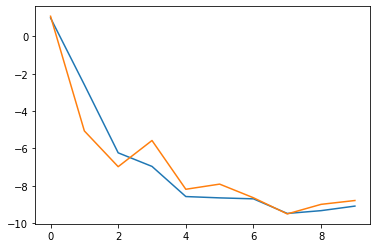

In [37]:
plt.plot(np.log(err_logRS))
plt.plot(np.log(err_logPS))
plt.show()